# "Parts of form" explorer

developed by Kow Kuroda (kow.kuroda@gmail.com)

Created 2024/09/13

Modifications
2025/08/01 i) added handling of Englsh WN3 word classification; ii) added gender sub-classification for Irish;
2025/08/02 i) added handling of Welsh;

In [29]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [30]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [31]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [32]:
## install Cython if necessary
#!conda install Cython -y

In [33]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [34]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [35]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"
print(f"mark_boundaries with {boundary_mark}: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

doc_type: spell
mark_boundaries with #: spell
max_doc_size: 11
min_doc_size: 5


In [36]:
## term settings
ngram_is_inclusive  = True
inclusion_degree    = None # or 1 # smaller values give better results

## term setting
#ngram_is_skippy       = False
skippy_means_extended = False

gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

accent_status: 


In [37]:
## select target files
import glob
data_dir1      = "data/open-dict-ipa/data1"
data_dir2      = "data/open-dict-ipa/data1a"
data_dir3      = "data/wn3"
data_dir4      = "data/irish"
data_dir5      = "data/welsh"
target_files   = glob.glob(f"{data_dir1}/*")
target_files2  = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3  = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4  = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
target_files5  = glob.glob(f"{data_dir5}/*")
target_files.extend(target_files5)
#
pp.pprint(target_files)

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_

In [38]:
## key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German noun',
                        'de_non_N_only' : 'German non-noun',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nb'    : 'Norwegian',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili',
                        'we'    : 'Welsh' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nb', 'nl', 'ro', 'sw',
                        'ir', 'we' # These lack sound
                    ]

In [39]:
## select language
target_lang_key  = target_lang_keys[-1]
print(f"target_lang_key: {target_lang_key}")
target_lang_name = target_lang_dict[target_lang_key]
print(f"target lang: {target_lang_name} [{target_lang_key}]")

target_lang_key: we
target lang: Welsh [we]


In [40]:
## select word class
selects_word_class = True

# non_N_only only for German; R_only is not available for Irish, Welsh
target_word_classes = [ 'A_only', 'N_only', 'non_N_only',
                       'R_only', 'V_only' ]
if not selects_word_class:
    target_word_class = None
else:
    #target_word_class = target_word_classes[0:1] + target_word_classes[-1:]
    target_word_class = target_word_classes[1]
print(f"target_word_class: {target_word_class}")

target_word_class: N_only


In [41]:
target_files_base = target_files.copy() # make a reserve
#
if selects_word_class:
    lang_key = target_lang_key.split("_")[0]
    print(f"lang_key: {lang_key}")
    print(f"target_word_class: {target_word_class}")
    if not target_word_class != 'non_N_only':
        target_files = [ f for f in target_files_base if not f"non_{target_word_class}" in f ]
    if type(target_word_class) == 'list':
        target_files = [ f for f in target_files if any(wc in f for wc in target_word_class) and lang_key in f ]
    else:
        target_files = [ f for f in target_files if target_word_class in f and lang_key in f ]
##
pp.pprint(target_files)

lang_key: we
target_word_class: N_only
['data/welsh/welsh-spell-N_only.csv']


In [69]:
## get source data from files
import pandas as pd
import gzip

for target_file in target_files:
    print(f"processing: {target_file}")
    if target_lang_key in ['ir', 'wl', 'we']:
        col_names = ['spell', 'POS']
    else:
        col_names = ['spell', 'sound']

    ##
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

    ## normalize characters
    raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

    ## modify sound
    try:
        sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
        sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
        raw_df['sound'] = sounds
    except (AttributeError, KeyError):
        pass
    #
raw_df.sample(30)

processing: data/welsh/welsh-spell-N_only.csv


,spell,POS
2114,llethrau,noun
1198,olion,noun
2888,marmor,noun
1726,kate,noun
845,gychwyniad,noun
179,bysgotwr,noun
1718,bryniau,noun
2983,cleddyf,noun
452,digrifwch,noun
2879,llundain,noun


In [70]:
## select gender
selects_gender = True

target_genders = [ 'fem', 'masc', 'neu' ] # neuter is effective for German only
target_gender = target_genders[0]
print(f"target_gender: {target_gender}")

## make a reserve
try:
    raw_df_origin
except NameError:
    raw_df_origin = raw_df.copy()
##
if target_lang_key in [ 'ir' ] and target_word_class in ['N_only'] and selects_gender:
    raw_df = raw_df_origin[raw_df_origin['POS'].apply(lambda x: x[:len(x)-1]) == target_gender]
else:
    target_gender = None
#
raw_df

target_gender: fem


,spell,POS
0,aber,noun
1,absenoldeb,noun
2,acenion,noun
3,achwyn,noun
4,adda,noun
...,...,...
3376,hyd,noun
3377,dim,noun
3378,edrych,noun
3379,nos,noun


## sampling

In [71]:
## source sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 3000
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		source_sampling_n = source_sampling_max_size
	else:
		source_sampling_n = round(len(raw_df) * source_sampling_rate)
	raw_df = raw_df.sample(source_sampling_n)
else:
	source_sampling_n = None

## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass

## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                spell   POS
541        #erlynwyr#  noun
1338          #sgrin#  noun
2802        #ddyddie#  noun
2137         #mhlith#  noun
199        #canwaith#  noun
...               ...   ...
1165     #nheimladau#  noun
1120  #nghamgymeriad#  noun
443        #deuddydd#  noun
1504       #wythnose#  noun
351         #cynnydd#  noun

[3000 rows x 2 columns]


In [72]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,POS,sp_1gram,sp_size,hyphen,period
541,#erlynwyr#,noun,"[#, e, r, l, y, n, w, y, r, #]",10,0,0
1338,#sgrin#,noun,"[#, s, g, r, i, n, #]",7,0,0
2802,#ddyddie#,noun,"[#, d, d, y, d, d, i, e, #]",9,0,0
2137,#mhlith#,noun,"[#, m, h, l, i, t, h, #]",8,0,0
199,#canwaith#,noun,"[#, c, a, n, w, a, i, t, h, #]",10,0,0
...,...,...,...,...,...,...
1165,#nheimladau#,noun,"[#, n, h, e, i, m, l, a, d, a, u, #]",12,0,0
1120,#nghamgymeriad#,noun,"[#, n, g, h, a, m, g, y, m, e, r, i, a, d, #]",15,0,0
443,#deuddydd#,noun,"[#, d, e, u, d, d, y, d, d, #]",10,0,0
1504,#wythnose#,noun,"[#, w, y, t, h, n, o, s, e, #]",10,0,0


In [73]:
## filtering raw_data by size
print(f"term_class: {doc_type}")
if "spell" == doc_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_class: spell


,spell,POS,sp_1gram,sp_size,hyphen,period
541,#erlynwyr#,noun,"[#, e, r, l, y, n, w, y, r, #]",10,0,0
1338,#sgrin#,noun,"[#, s, g, r, i, n, #]",7,0,0
2802,#ddyddie#,noun,"[#, d, d, y, d, d, i, e, #]",9,0,0
2137,#mhlith#,noun,"[#, m, h, l, i, t, h, #]",8,0,0
199,#canwaith#,noun,"[#, c, a, n, w, a, i, t, h, #]",10,0,0
...,...,...,...,...,...,...
43,#ansoddau#,noun,"[#, a, n, s, o, d, d, a, u, #]",10,0,0
680,#ganiatad#,noun,"[#, g, a, n, i, a, t, a, d, #]",10,0,0
443,#deuddydd#,noun,"[#, d, e, u, d, d, y, d, d, #]",10,0,0
1504,#wythnose#,noun,"[#, w, y, t, h, n, o, s, e, #]",10,0,0


In [74]:
## second sampling if needed
second_sampling          = False
second_sampling_rate     = 0.7
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

2717

# Functions

In [75]:
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

In [76]:
def get_terms_by_freq_rank(dfx, rank_range: tuple, prefix: str = "", n_for_ngram: int = 2, skippy: bool = False, gap_mark: str = "…", check = False):
    "return list of most N frequent terms"
    import collections
    ## define variables
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = "" 
    var_name = f'{prefix}{skippiness}{n_for_ngram}gram'
    if check:
        print(f"var_name: {var_name}")
    ## main
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_for_ngram]) for L in dfx[var_name] ]
    if check:
        print(G)
    ## filtering data
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if check:
        print(f"highest_rank: {highest_rank}; lowest_rank: {lowest_rank}")
    R = collections.Counter(G).most_common(lowest_rank)
    R = R[(highest_rank - 1):]
    if check:
        print(R)
    ## return
    return R

In [77]:
def show_terms_with_ranking(ranking, rank_range: tuple, n_for_ngram: int, skippy: bool, prefix: str = "", lang: str = target_lang_name, word_class: str = target_word_class, gender: str = target_gender, check = False):
    "display terms with a given frequency rank range"
    ## imports
    import matplotlib.pyplot as plt
    ## variables
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = ""
    target_var_name = f"{prefix}{skippiness}{n_for_ngram}g"

    ## get freq data
    ranking = sorted(ranking, key = lambda x: x[1], reverse = False)
    terms, freqs = [ ], [ ]
    for x in ranking:
        term, freq = x[0], x[1]
        if len(term) > 0 and freq > 0:
            terms.append(term)
            freqs.append(freq)

    ## plot
    plt.figure(figsize = (6, 0.25 * len(terms)))
    plt.autoscale(enable = True, axis = 'y', tight = True)
    plt.barh(terms, freqs)
    if gender is None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class}) "
    else:
        title_val = f"Freq-ranked distribution [rank {highest_rank} - rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class} with gender: {gender}) "
    plt.title(title_val)
    plt.plot()

# Main

In [78]:
# frequency rank range for terms to show
highest_freq_rank_for_terms_to_show = 1
lowest_freq_rank_for_terms_to_show  = 100
rank_range  = (highest_freq_rank_for_terms_to_show, lowest_freq_rank_for_terms_to_show)
print(f"rank_range: {rank_range}")

rank_range: (1, 100)


## Spell

### Non-skippy spell

In [79]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
541     [#e, er, rl, ly, yn, nw, wy, yr, r#, #, e, r, ...
1338        [#s, sg, gr, ri, in, n#, #, s, g, r, i, n, #]
2802    [#d, dd, dy, yd, dd, di, ie, e#, #, d, d, y, d...
2137    [#m, mh, hl, li, it, th, h#, #, m, h, l, i, t,...
199     [#c, ca, an, nw, wa, ai, it, th, h#, #, c, a, ...
                              ...                        
43      [#a, an, ns, so, od, dd, da, au, u#, #, a, n, ...
680     [#g, ga, an, ni, ia, at, ta, ad, d#, #, g, a, ...
443     [#d, de, eu, ud, dd, dy, yd, dd, d#, #, d, e, ...
1504    [#w, wy, yt, th, hn, no, os, se, e#, #, w, y, ...
351     [#c, cy, yn, nn, ny, yd, dd, d#, #, c, y, n, n...
Name: sp_2gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


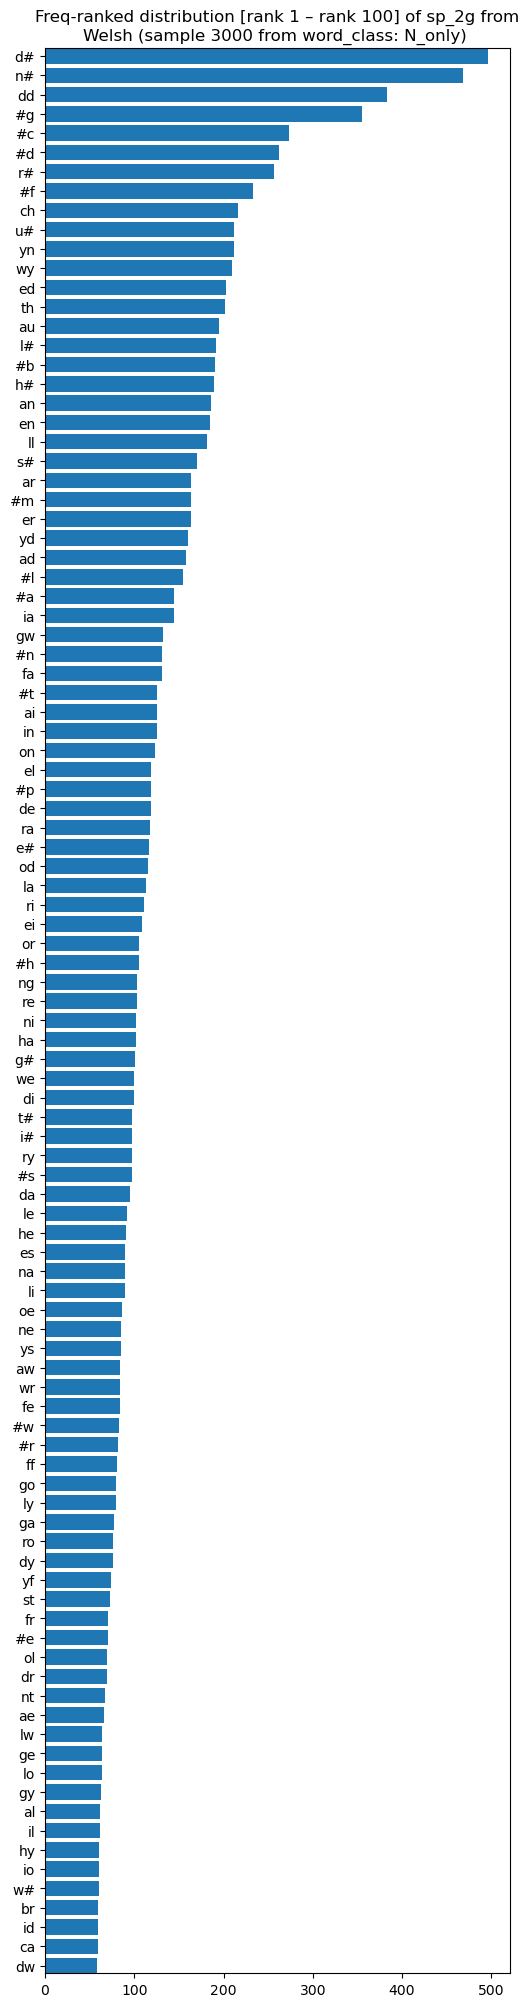

In [80]:
## frequency-ranked view
skippy = False
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [81]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
541     [#er, erl, rly, lyn, ynw, nwy, wyr, yr#, #e, e...
1338    [#sg, sgr, gri, rin, in#, #s, sg, gr, ri, in, ...
2802    [#dd, ddy, dyd, ydd, ddi, die, ie#, #d, dd, dy...
2137    [#mh, mhl, hli, lit, ith, th#, #m, mh, hl, li,...
199     [#ca, can, anw, nwa, wai, ait, ith, th#, #c, c...
                              ...                        
43      [#an, ans, nso, sod, odd, dda, dau, au#, #a, a...
680     [#ga, gan, ani, nia, iat, ata, tad, ad#, #g, g...
443     [#de, deu, eud, udd, ddy, dyd, ydd, dd#, #d, d...
1504    [#wy, wyt, yth, thn, hno, nos, ose, se#, #w, w...
351     [#cy, cyn, ynn, nny, nyd, ydd, dd#, #c, cy, yn...
Name: sp_3gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


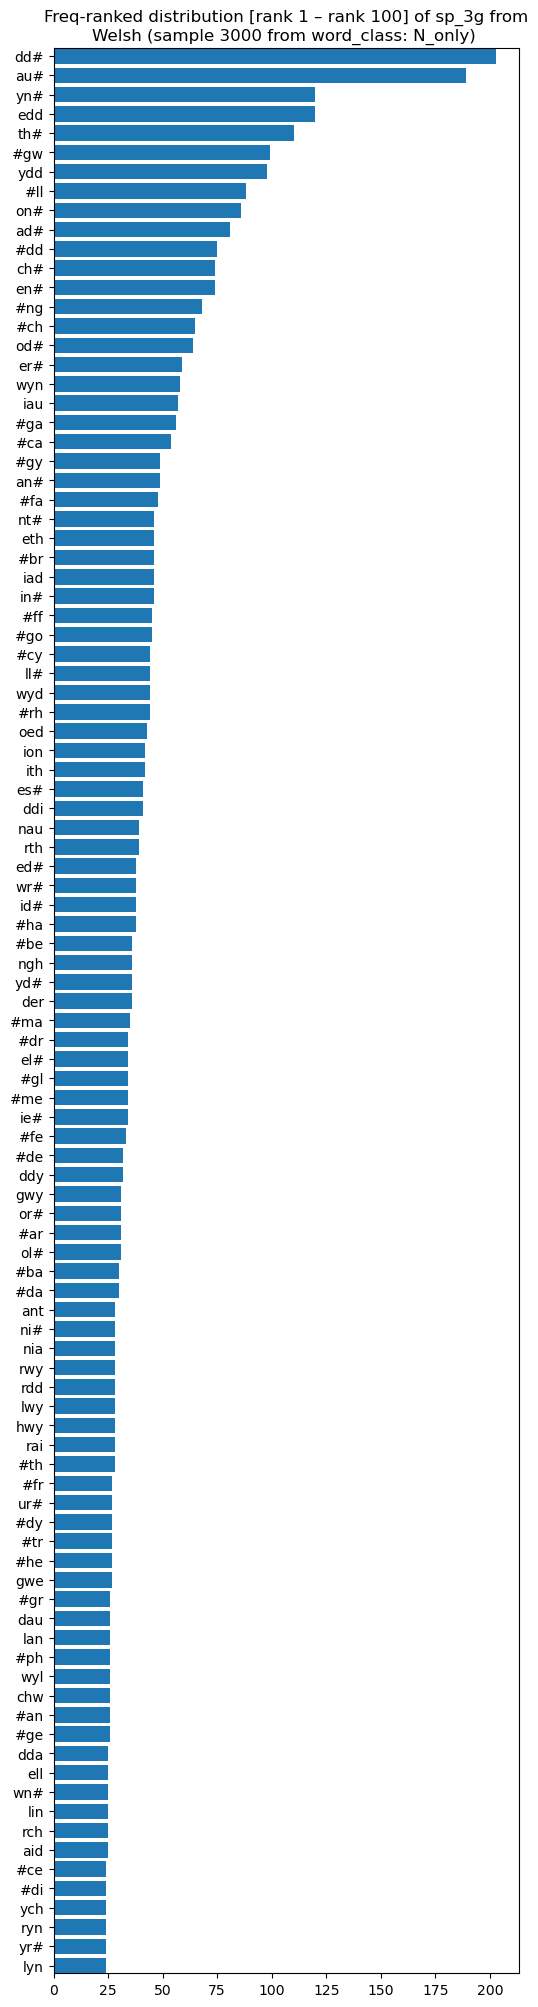

In [82]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [83]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
541     [#erl, erly, rlyn, lynw, ynwy, nwyr, wyr#, #er...
1338    [#sgr, sgri, grin, rin#, #sg, sgr, gri, rin, i...
2802    [#ddy, ddyd, dydd, yddi, ddie, die#, #dd, ddy,...
2137    [#mhl, mhli, hlit, lith, ith#, #mh, mhl, hli, ...
199     [#can, canw, anwa, nwai, wait, aith, ith#, #ca...
                              ...                        
43      [#ans, anso, nsod, sodd, odda, ddau, dau#, #an...
680     [#gan, gani, ania, niat, iata, atad, tad#, #ga...
443     [#deu, deud, eudd, uddy, ddyd, dydd, ydd#, #de...
1504    [#wyt, wyth, ythn, thno, hnos, nose, ose#, #wy...
351     [#cyn, cynn, ynny, nnyd, nydd, ydd#, #cy, cyn,...
Name: sp_4gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


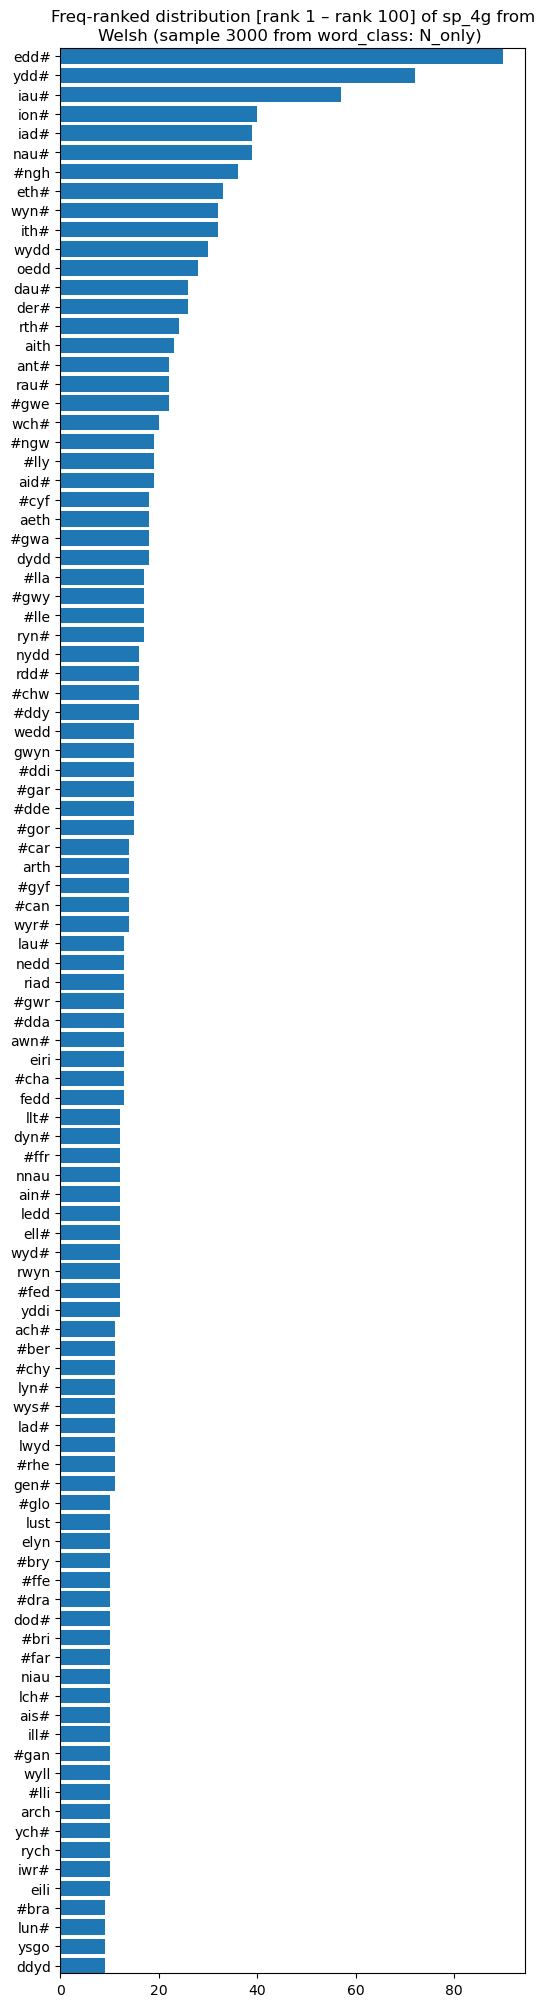

In [84]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [85]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
541     [#erly, erlyn, rlynw, lynwy, ynwyr, nwyr#, #er...
1338    [#sgri, sgrin, grin#, #sgr, sgri, grin, rin#, ...
2802    [#ddyd, ddydd, dyddi, yddie, ddie#, #ddy, ddyd...
2137    [#mhli, mhlit, hlith, lith#, #mhl, mhli, hlit,...
199     [#canw, canwa, anwai, nwait, waith, aith#, #ca...
                              ...                        
43      [#anso, ansod, nsodd, sodda, oddau, ddau#, #an...
680     [#gani, gania, aniat, niata, iatad, atad#, #ga...
443     [#deud, deudd, euddy, uddyd, ddydd, dydd#, #de...
1504    [#wyth, wythn, ythno, thnos, hnose, nose#, #wy...
351     [#cynn, cynny, ynnyd, nnydd, nydd#, #cyn, cynn...
Name: sp_5gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


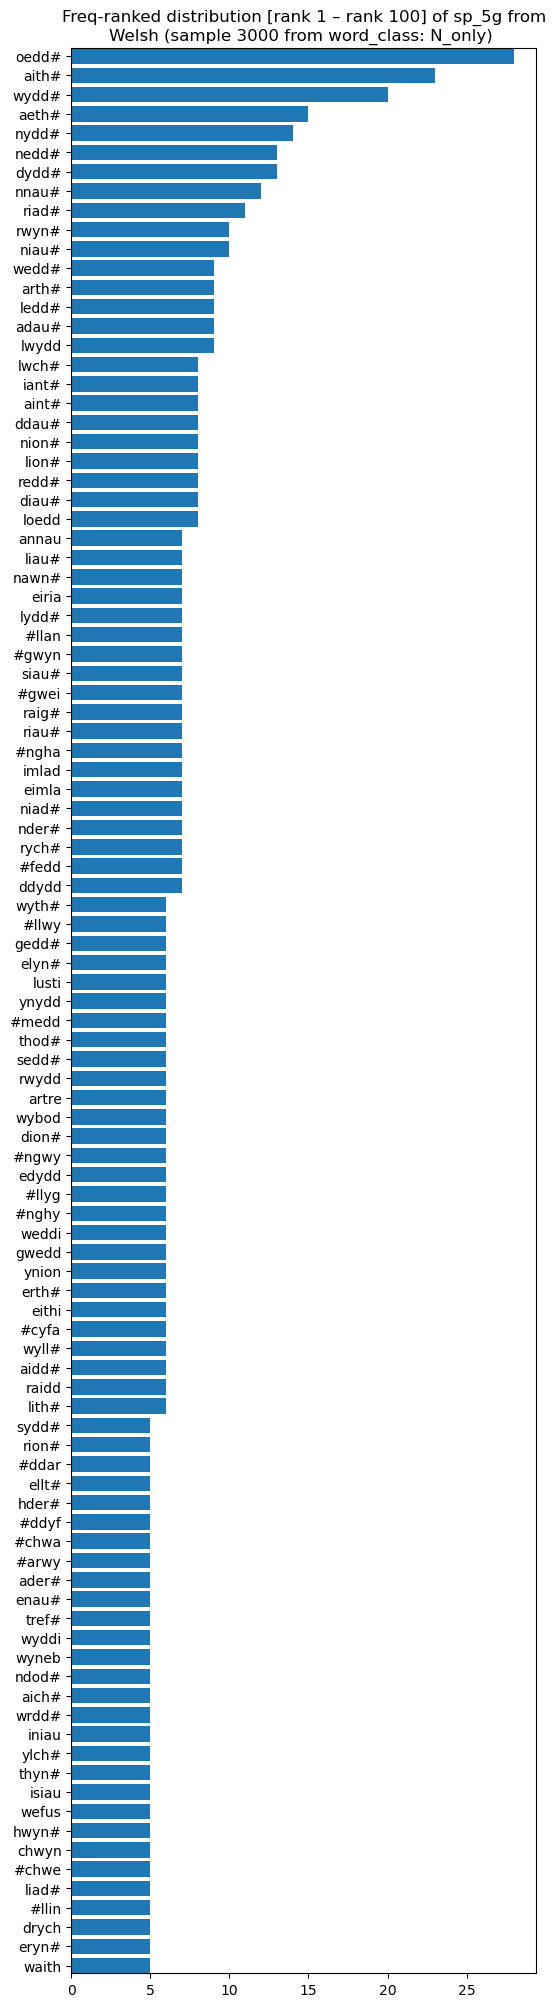

In [86]:
## frequency-rank view
skippy = False
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy spell

In [87]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk2gram
min_size: 1
supplement_var: sp_1gram
541     [#e, #…r, #…l, #…y, #…n, #…w, #…y, #…r, #…#, e...
1338    [#s, #…g, #…r, #…i, #…n, #…#, sg, s…r, s…i, s…...
2802    [#d, #…d, #…y, #…d, #…d, #…i, #…e, #…#, dd, d…...
2137    [#m, #…h, #…l, #…i, #…t, #…h, #…#, mh, m…l, m…...
199     [#c, #…a, #…n, #…w, #…a, #…i, #…t, #…h, #…#, c...
                              ...                        
43      [#a, #…n, #…s, #…o, #…d, #…d, #…a, #…u, #…#, a...
680     [#g, #…a, #…n, #…i, #…a, #…t, #…a, #…d, #…#, g...
443     [#d, #…e, #…u, #…d, #…d, #…y, #…d, #…d, #…#, d...
1504    [#w, #…y, #…t, #…h, #…n, #…o, #…s, #…e, #…#, w...
351     [#c, #…y, #…n, #…n, #…y, #…d, #…d, #…#, cy, c…...
Name: sp_sk2gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


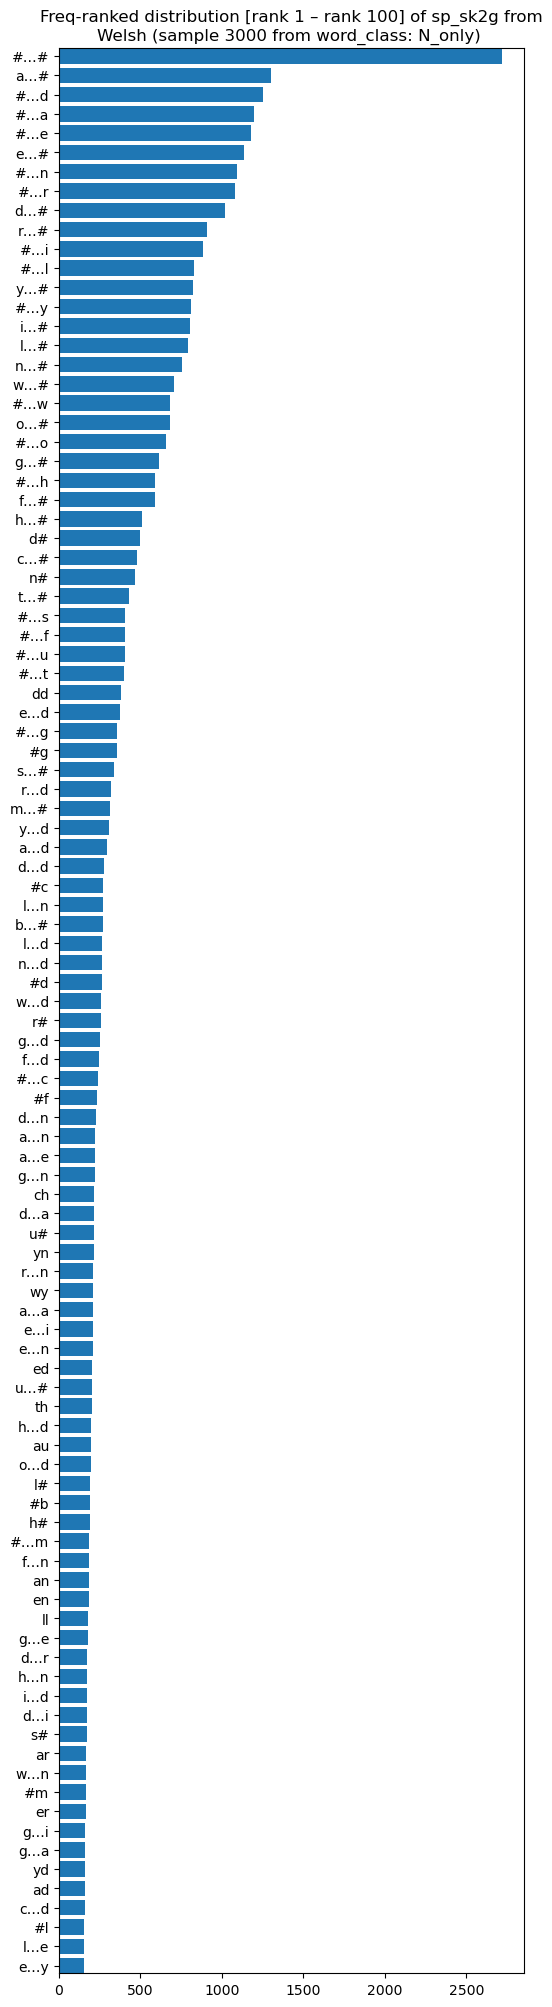

In [88]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [89]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk3gram
min_size: 1
supplement_var: sp_sk2gram
541     [#er, #e…l, #e…y, #e…n, #e…w, #e…y, #e…r, #e…#...
1338    [#sg, #s…r, #s…i, #s…n, #s…#, #…gr, #…g…i, #…g...
2802    [#dd, #d…y, #d…d, #d…d, #d…i, #d…e, #d…#, #…dy...
2137    [#mh, #m…l, #m…i, #m…t, #m…h, #m…#, #…hl, #…h…...
199     [#ca, #c…n, #c…w, #c…a, #c…i, #c…t, #c…h, #c…#...
                              ...                        
43      [#an, #a…s, #a…o, #a…d, #a…d, #a…a, #a…u, #a…#...
680     [#ga, #g…n, #g…i, #g…a, #g…t, #g…a, #g…d, #g…#...
443     [#de, #d…u, #d…d, #d…d, #d…y, #d…d, #d…d, #d…#...
1504    [#wy, #w…t, #w…h, #w…n, #w…o, #w…s, #w…e, #w…#...
351     [#cy, #c…n, #c…n, #c…y, #c…d, #c…d, #c…#, #…yn...
Name: sp_sk3gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


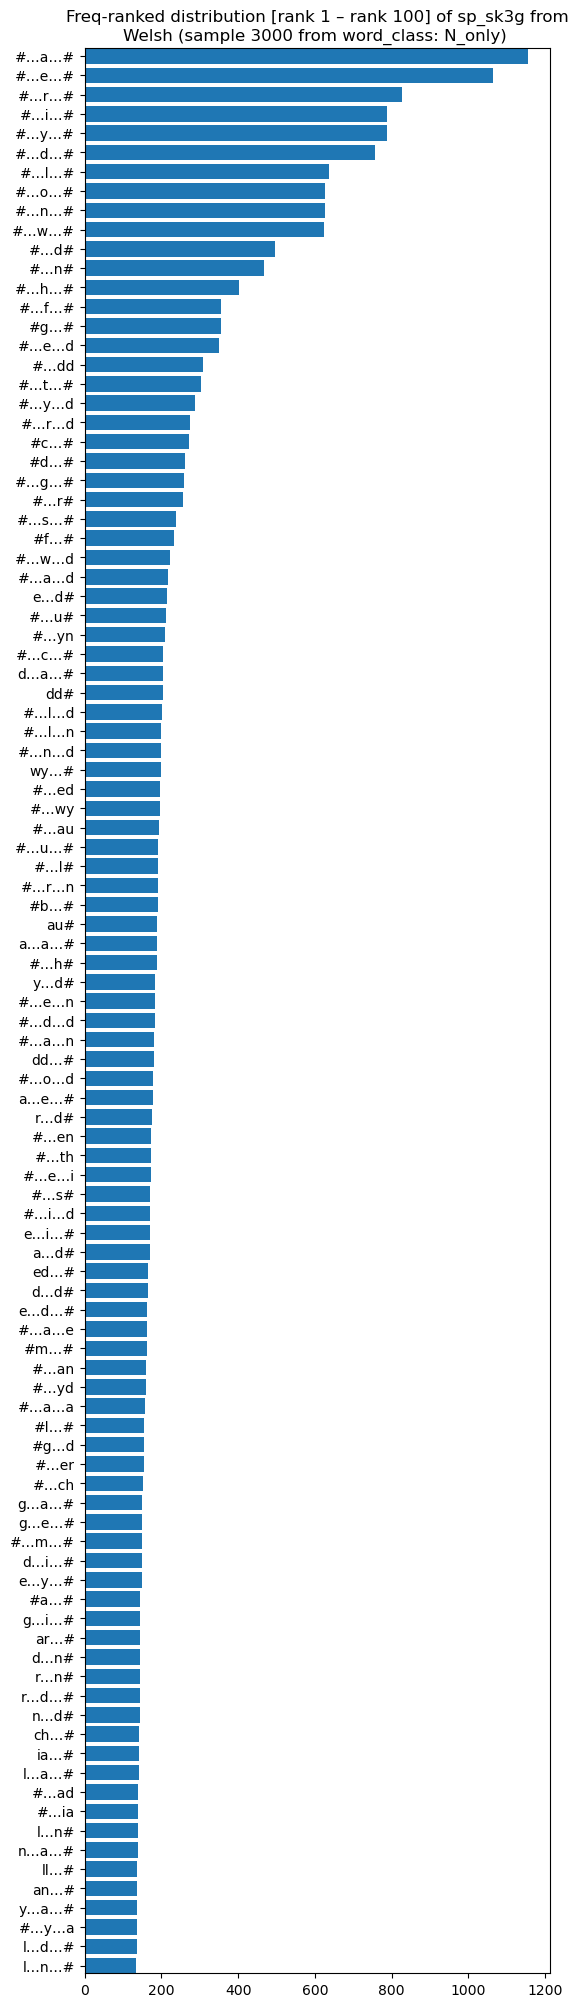

In [90]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [91]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk4gram
min_size: 1
supplement_var: sp_sk3gram
541     [#erl, #er…y, #er…n, #er…w, #er…y, #er…r, #er…...
1338    [#sgr, #sg…i, #sg…n, #sg…#, #s…ri, #s…r…n, #s…...
2802    [#ddy, #dd…d, #dd…d, #dd…i, #dd…e, #dd…#, #d…y...
2137    [#mhl, #mh…i, #mh…t, #mh…h, #mh…#, #m…li, #m…l...
199     [#can, #ca…w, #ca…a, #ca…i, #ca…t, #ca…h, #ca…...
                              ...                        
43      [#ans, #an…o, #an…d, #an…d, #an…a, #an…u, #an…...
680     [#gan, #ga…i, #ga…a, #ga…t, #ga…a, #ga…d, #ga…...
443     [#deu, #de…d, #de…d, #de…y, #de…d, #de…d, #de…...
1504    [#wyt, #wy…h, #wy…n, #wy…o, #wy…s, #wy…e, #wy…...
351     [#cyn, #cy…n, #cy…y, #cy…d, #cy…d, #cy…#, #c…n...
Name: sp_sk4gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


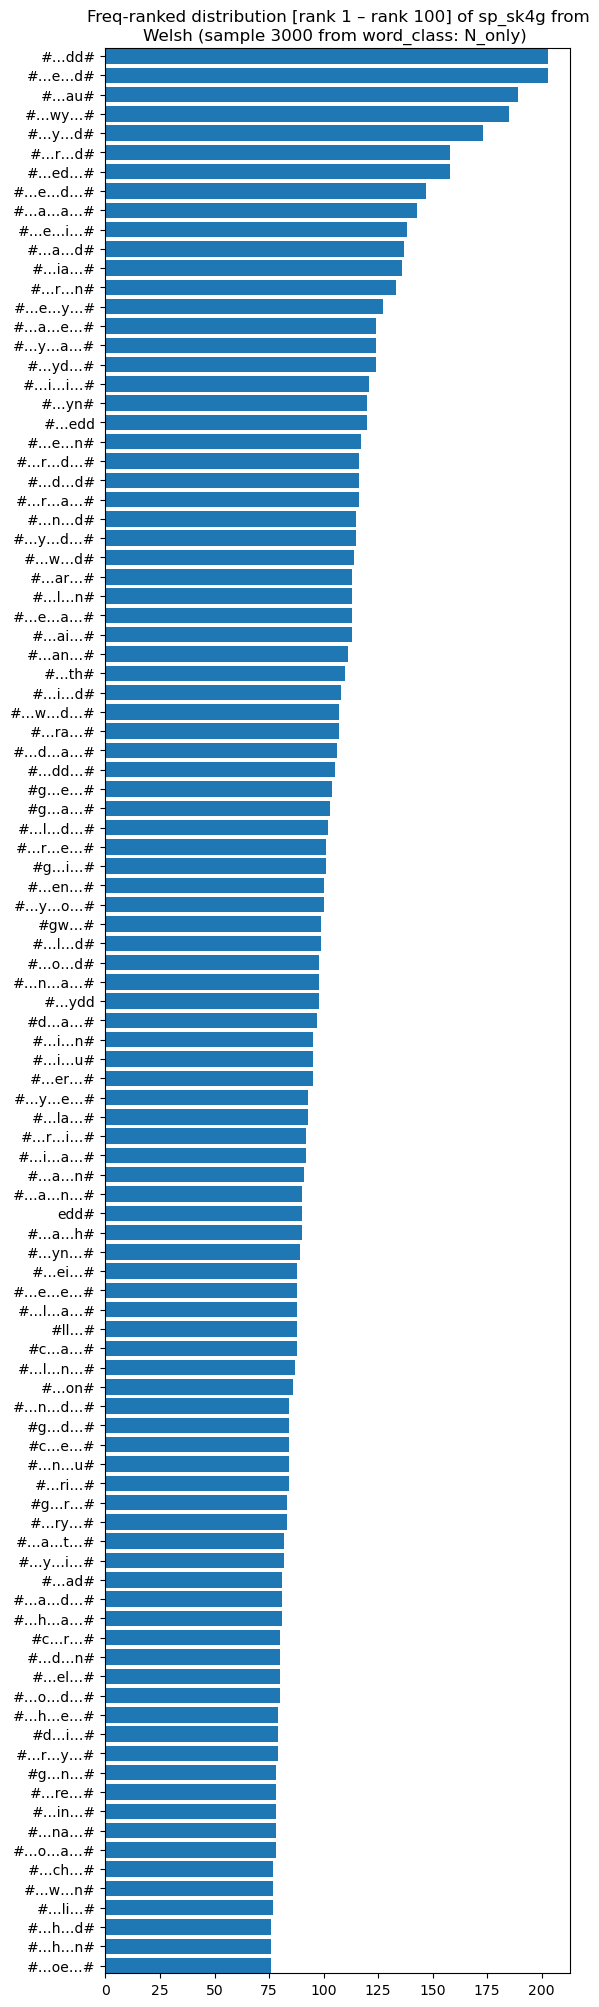

In [92]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [93]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk5gram
min_size: 1
supplement_var: sp_sk4gram
541     [#erly, #erl…n, #erl…w, #erl…y, #erl…r, #erl…#...
1338    [#sgri, #sgr…n, #sgr…#, #sg…in, #sg…i…#, #sg…n...
2802    [#ddyd, #ddy…d, #ddy…i, #ddy…e, #ddy…#, #dd…dd...
2137    [#mhli, #mhl…t, #mhl…h, #mhl…#, #mh…it, #mh…i…...
199     [#canw, #can…a, #can…i, #can…t, #can…h, #can…#...
                              ...                        
43      [#anso, #ans…d, #ans…d, #ans…a, #ans…u, #ans…#...
680     [#gani, #gan…a, #gan…t, #gan…a, #gan…d, #gan…#...
443     [#deud, #deu…d, #deu…y, #deu…d, #deu…d, #deu…#...
1504    [#wyth, #wyt…n, #wyt…o, #wyt…s, #wyt…e, #wyt…#...
351     [#cynn, #cyn…y, #cyn…d, #cyn…d, #cyn…#, #cy…ny...
Name: sp_sk5gram, Length: 2717, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_77927/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


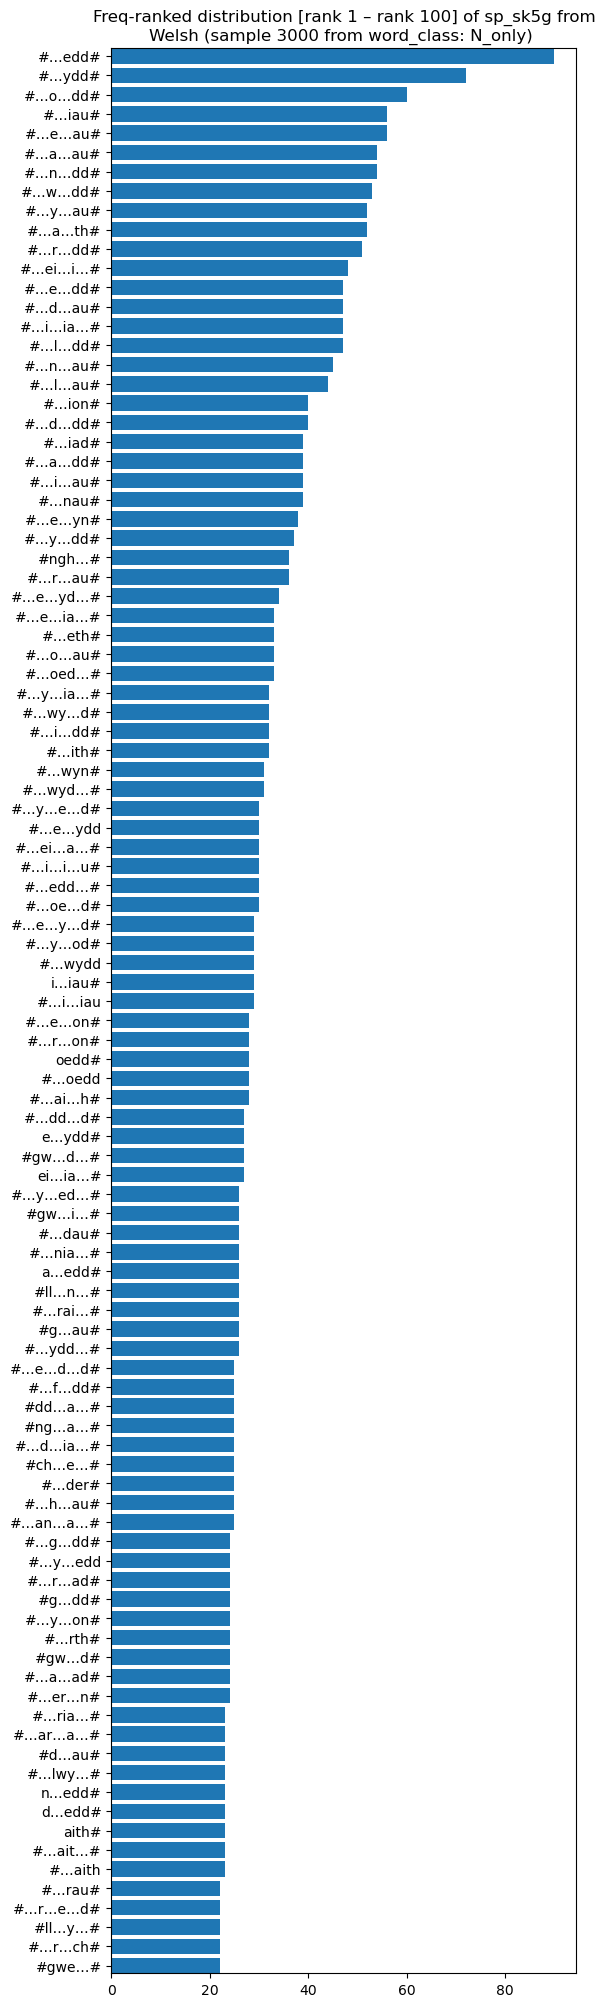

In [94]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

## Sound

In [95]:
## stop for unimplemented language
if target_lang_name in [ 'Irish', 'Welsh' ]:
    import sys
    sys.exit()

SystemExit: 

/Users/kowk/anaconda3/envs/py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Non-skippy sound

In [ ]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
1762    [#v, ve, er, rb, b#, #, v, e, r, b, #]
2141    [#v, ve, er, rb, b#, #, v, e, r, b, #]
120     [#v, ve, er, rb, b#, #, v, e, r, b, #]
467     [#v, ve, er, rb, b#, #, v, e, r, b, #]
1032    [#v, ve, er, rb, b#, #, v, e, r, b, #]
                         ...                  
155     [#v, ve, er, rb, b#, #, v, e, r, b, #]
469     [#v, ve, er, rb, b#, #, v, e, r, b, #]
2429    [#v, ve, er, rb, b#, #, v, e, r, b, #]
93      [#v, ve, er, rb, b#, #, v, e, r, b, #]
1503    [#v, ve, er, rb, b#, #, v, e, r, b, #]
Name: sn_2gram, Length: 1122, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


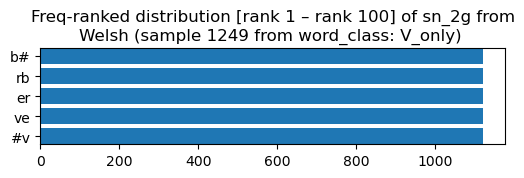

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


1762    [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
2141    [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
120     [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
467     [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
1032    [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
                              ...                        
155     [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
469     [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
2429    [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
93      [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
1503    [#ve, ver, erb, rb#, #v, ve, er, rb, b#, #, v,...
Name: sn_3gram, Length: 1122, dtype: object


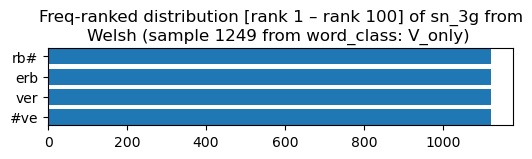

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
1762    [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
2141    [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
120     [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
467     [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
1032    [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
                              ...                        
155     [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
469     [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
2429    [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
93      [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
1503    [#ver, verb, erb#, #ve, ver, erb, rb#, #v, ve,...
Name: sn_4gram, Length: 1122, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


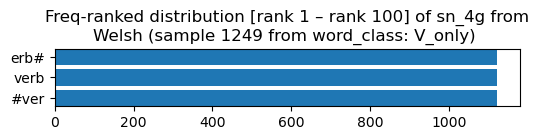

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
1762    [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
2141    [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
120     [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
467     [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
1032    [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
                              ...                        
155     [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
469     [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
2429    [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
93      [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
1503    [#verb, verb#, #ver, verb, erb#, #ve, ver, erb...
Name: sn_5gram, Length: 1122, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


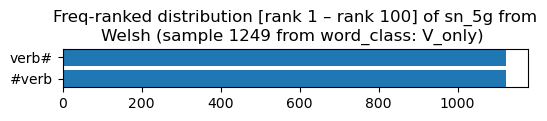

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy sound

In [ ]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk2gram
min_size: 1
supplement_var: sn_1gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


1762    [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
2141    [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
120     [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
467     [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
1032    [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
                              ...                        
155     [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
469     [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
2429    [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
93      [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
1503    [#v, #…e, #…r, #…b, #…#, ve, v…r, v…b, v…#, er...
Name: sn_sk2gram, Length: 1122, dtype: object


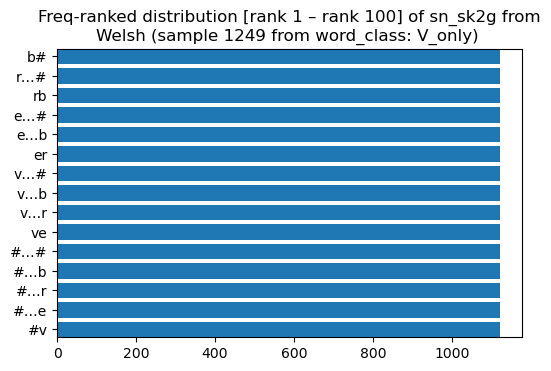

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk3gram
min_size: 1
supplement_var: sn_sk2gram
1762    [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
2141    [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
120     [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
467     [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
1032    [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
                              ...                        
155     [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
469     [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
2429    [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
93      [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
1503    [#ve, #v…r, #v…b, #v…#, #…er, #…e…b, #…e…#, #…...
Name: sn_sk3gram, Length: 1122, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


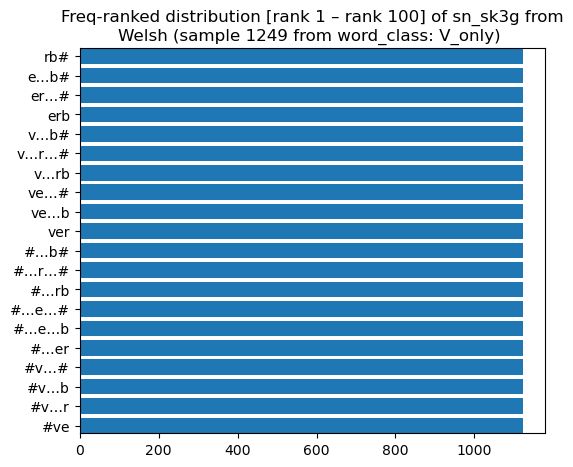

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk4gram
min_size: 1
supplement_var: sn_sk3gram
1762    [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
2141    [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
120     [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
467     [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
1032    [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
                              ...                        
155     [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
469     [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
2429    [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
93      [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
1503    [#ver, #ve…b, #ve…#, #v…rb, #v…r…#, #v…b#, #…e...
Name: sn_sk4gram, Length: 1122, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


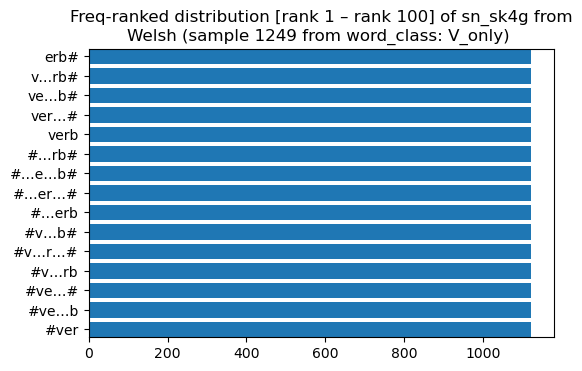

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk5gram
min_size: 1
supplement_var: sn_sk4gram
1762    [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
2141    [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
120     [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
467     [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
1032    [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
                              ...                        
155     [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
469     [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
2429    [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
93      [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
1503    [#verb, #ver…#, #ve…b#, #v…rb#, #…erb#, verb#,...
Name: sn_sk5gram, Length: 1122, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_23093/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


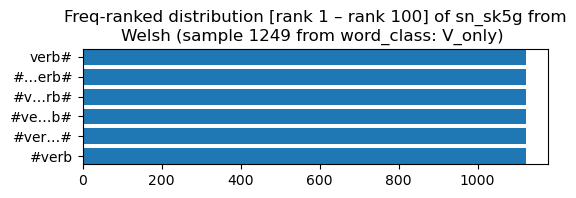

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

# End